In [11]:
import xarray as xr
import utils.agcd_agg_functions as agg
from importlib import reload
from shapely.geometry import mapping, box
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray
import numpy as np
from rasterio.enums import Resampling
from rasterio.features import geometry_mask
import dill
import pandas as pd
from pathlib import Path
from collections import defaultdict

pd.set_option('display.max_columns',  None)

reload(agg)

<module 'utils.agcd_agg_functions' from 'c:\\Users\\jake.allen.ALLUVIUMQLD\\Documents\\Repos\\climate_health_reference_manual\\utils\\agcd_agg_functions.py'>

### Paths to NetCDF files
We load everything into xarray dataset definitions for easy iterations later. Note that no data is being held in memory yet thanks to dask. This only happens once computations are triggered later.

In [2]:
# build path dictionary
clim_fold = 'E:/Jake_ClimateRasters'

def nested_dict():
    return defaultdict(lambda: defaultdict(list))

path_dict = defaultdict(lambda: defaultdict(nested_dict))

models = ['ACCESS-ESM1-5']
ssps = ['ssp245', 'ssp370']
epochs = ['mid', 'late']
vars = ['hurs', 'tasmax', 'tasmin']

# assign model paths
for model in models:
    for ssp in ssps:
        for epoch in epochs:
            thisepoch = '2035-2064' if epoch == 'mid' else '2070-2099'
            for thisvar in vars:
                thispath = Path(f'{clim_fold}/{model}/{ssp}/{thisvar}/AUS-11/{thisepoch}')
                ncdfs = []
                for path in thispath.rglob('*.nc'):
                    ncdfs.append(path)
                path_dict[model][ssp][epoch][thisvar] = ncdfs

# assign historical observation paths
for thisvar in vars:
    thispath = Path(f'{clim_fold}/Historical/{thisvar}')
    ncdfs = []
    for path in thispath.rglob('*.nc'):
        ncdfs.append(path)
    path_dict['Historical'][thisvar] = ncdfs



In [3]:
# load districts

districts = gpd.read_file('Inputs/health_district_merged.json')

# subset districts if necessary
sub = districts[districts['health_district_name'].isin(['Northern NSW', 'Western Sydney', 'Eyre and Far North'])].copy().to_crs('EPSG:4326')

# get bounding box
minx, miny, maxx, maxy = sub.total_bounds

bbox_geom = box(minx, miny, maxx, maxy)
bbox = [mapping(bbox_geom)]


In [4]:
# Load ncdfs into dictionary for easy wrangling, subsetting to bounding box and chunking by time = 365
# use load_var helper function

# initalise empty dictionary
data_dict = defaultdict(lambda: defaultdict(nested_dict))

# load model data
for model in models:
    for ssp in ssps:
        for epoch in epochs:
            ds = xr.Dataset({
                var: agg.load_var(path_dict[model][ssp][epoch][var], var, bbox)
                for var in vars
            })
            data_dict[model][ssp][epoch] = ds


# Load all historical variables into a dict
# historical data has misaligned time coordinates, causing issues when combining into a single dataset
hist_vars = {}
for thisvar in vars:
    ds = agg.load_var(path_dict['Historical'][thisvar], thisvar, bbox, chunk=False)

    # Force matching time coordinates
    if 'time' in hist_vars:
        ds['time'] = hist_vars['time']
    else:
        hist_vars['time'] = ds['time']

    hist_vars[thisvar] = ds

# Drop the saved 'time' array from the dict
hist_vars.pop('time')

# Now build the dataset
data_dict['Historical'] = xr.Dataset(hist_vars)


## Calculate metrics

#### Define mean temperature and heat index
These metrics need to be calculated for each day throughout the time series. Here we are just defining the metrics, not triggering the dask computation yet.

In [ ]:
# iterate through each dataset to define mean temp and heat index. Heat index is using a function pulled from our utils functions file.
# Also define 95th percentile mean just for historical.

for model in models:
    for ssp in ssps:
        for epoch in epochs:
                ds = data_dict[model][ssp][epoch]
                # mean temp
                ds['tas'] = (ds['tasmax'] + ds['tasmin']) / 2
                # heat index
                ds['hi'] = agg.calculate_heat_index(ds['tasmax'], ds['hurs'])

hist = data_dict['Historical']
hist['tas'] = (hist['tasmax'] + hist['tasmin']) / 2
hist['hi'] = agg.calculate_heat_index(hist['tasmax'], hist['hurs'])

##### Average hot days (thresholds) per year

In [ ]:
hot_days_dict = defaultdict(lambda: defaultdict(nested_dict))

for model in models:
    for ssp in ssps:
        for epoch in epochs:
            ds = data_dict[model][ssp][epoch]
            hot_days_dict[model][ssp][epoch] = {
                thresh: agg.calculate_avg_hot_days(ds, threshold=thresh).compute()
                for thresh in [35,40]
            }

hot_days_dict['Historical']['Historical']['Historical'] = {
        thresh: agg.calculate_avg_hot_days(data_dict['Historical'], threshold=thresh).compute()
        for thresh in [35, 40]
}

#### Percentile temps maximum 95%

In [ ]:
# create dict to store ncdf results to
pc_max_95_dict = defaultdict(lambda: defaultdict(nested_dict))

for model in models:
    for ssp in ssps:
        for epoch in epochs:
            ds = data_dict[model][ssp][epoch]
            pc_95_max = agg.calculate_percentile(ds, 'tasmax').compute()
            ds = data_dict[model][ssp][epoch] = pc_95_max

# historical
ds = data_dict['Historical']
pc_95_max = agg.calculate_percentile(ds, 'tasmax').compute()
pc_max_95_dict['Historical']['Historical']['Historical'] = pc_95_max

#### Percentile temps minimum, 95%
can probably turn this into a loop with max, but sometimes useful to run seperately

In [ ]:
# create dict to store ncdf results to
pc_min_95_dict = defaultdict(lambda: defaultdict(nested_dict))

for model in models:
    for ssp in ssps:
        for epoch in epochs:
            ds = data_dict[model][ssp][epoch]
            pc_95_min = agg.calculate_percentile(ds, 'tasmin').compute()
            ds = data_dict[model][ssp][epoch] = pc_95_min

# historical
ds = data_dict['Historical']
pc_95_min = agg.calculate_percentile(ds, 'tasmin').compute()
pc_min_95_dict['Historical']['Historical']['Historical'] = pc_95_min

#### Heat Index 95%

In [ ]:
# create dict to store ncdf results to
pc_hi_95_dict = {}

for model in models:
    for ssp in ssps:
        for epoch in epochs:
            ds = data_dict[model][ssp][epoch]
            pc_95_hi = agg.calculate_percentile(ds, 'hi').compute()
            pc_hi_95_dict[model][ssp][epoch] = pc_95_hi

# historical
ds = data_dict['Historical']
pc_95_hi = agg.calculate_percentile(ds, 'hi').compute()
pc_hi_95_dict['Historical']['Historical']['Historical']  = pc_95_hi

#### Heat Index mean

In [ ]:
mean_hi_dict = {}

# mean heat index for whole period
for model in models:
    for ssp in ssps:
        for epoch in epochs:
            ds = data_dict[model][ssp][epoch]
            hi_mean = ds['hi'].mean(dim='time').compute()
            mean_hi_dict[model][ssp][epoch] = hi_mean

# historical
ds = data_dict['Historical']
hi_mean = ds['hi'].mean(dim='time').compute()
mean_hi_dict['Historical']['Historical']['Historical']  = hi_mean

##### Mean temp mean

In [ ]:
mean_mean_dict = {}

# mean temperature for the whole period
for model in models:
    for ssp in ssps:
        for epoch in epochs:
            ds = data_dict[model][ssp][epoch]
            mean_mean = ds['tas'].mean(dim='time').compute()
            mean_mean_dict[model][ssp][epoch] = mean_mean

# historical
ds = data_dict['Historical']
mean_mean = ds['tas'].mean(dim='time').compute()
mean_mean_dict['Historical']['Historical']['Historical'] = mean_mean

#### 95th percentile of historical mean temp for EHF

#### Excess Heat Factor (EHF) (Heatwave days)

In [ ]:
# compute 95th percentile of historical mean temperature
mean_95_hist = agg.calculate_percentile(data_dict['Historical'], 'tas', 95)

ehf_dict = {}

# mean temperature for the whole period
for model in models:
    for ssp in ssps:
        for epoch in epochs:
            ds = data_dict[model][ssp][epoch]
            ehf = agg.calculate_avg_ehf_days(ds['tas'], mean_95_hist).compute()
            ehf_dict[model][ssp][epoch] = ehf

# historical
ds = data_dict['Historical']
ehf = agg.calculate_avg_ehf_days(ds['tas'], mean_95_hist).compute()
ehf_dict['Historical']['Historical']['Historical'] = ehf

C:\Users\jake.allen.ALLUVIUMQLD\AppData\Local\anaconda3\envs\climate-env\Lib\site-packages\dask\array\core.py:5092: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
C:\Users\jake.allen.ALLUVIUMQLD\AppData\Local\anaconda3\envs\climate-env\Lib\site-packages\dask\array\core.py:5092: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
C:\Users\jake.allen.ALLUVIUMQLD\AppData\Local\anaconda3\envs\climate-env\Lib\site-packages\dask\array\core.py:5092: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
C:\Users\jake.allen.ALLUVIUMQLD\AppData\Local\anaconda3\envs\climate-env\Lib\site-packages\dask\array\core.py:5092: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(


#### Combine metric dictionaries

In [ ]:
metric_dicts = {
    'ehf': ehf_dict,
    'pc_max_95': pc_max_95_dict,
    'pc_min_95': pc_min_95_dict,
    'mean_heat_index': mean_hi_dict,
    'mean_temp': mean_mean_dict,
    'avg_hot_days': hot_days_dict
}

#### Population weighting - resample and align population raster to netcdfs.

In [66]:
# open population raster
pop = rioxarray.open_rasterio("Inputs/australian_pop_grid_2024/apg24e_1_0_0.tif").squeeze() # remove band dimension

# ensure correct projections are assinged (GDA94 for pop grid, WGS 84 for netcdfs)
pop.rio.write_crs("EPSG:3577", inplace=True)
# convert -1 to NaN and set as no data
pop = pop.where(pop != -1, np.nan)
pop = pop.rio.write_nodata(np.nan, inplace=False)

ref = data_dict['Historical']['hurs'].isel(time=0)
ref.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)

# reproject and resample, summing values as the resample method
pop_aligned = pop.rio.reproject_match(
    ref,
    resampling=Resampling.sum)

#### Build metrics dataframe - applying population weighting to health districts

In [62]:
# retrieve health districts and reproject to match.

all_districts = gpd.read_file('Inputs/health_district_merged.json')

# subset
districts = all_districts[all_districts['health_district_name'].isin(['Northern NSW', 'Western Sydney', 'Eyre and Far North'])].copy()

districts.to_crs(pop_aligned.rio.crs)

,OBJECTID,state,health_district_name,Shape_Length,Shape_Area,district_id,geometry
6,7,New South Wales,Northern NSW,11.494546,1.989182,NSW_7,"MULTIPOLYGON (((153.63873 -28.6361, 153.63869 ..."
8,9,New South Wales,Western Sydney,7.340251,0.686059,NSW_9,"POLYGON ((150.98407 -33.38804, 150.98402 -33.3..."
38,39,South Australia,Eyre and Far North,57.676729,46.122717,SA_5,"MULTIPOLYGON (((135.95444 -35.00627, 135.9545 ..."


In [ ]:

# Prepare geometries and affine transformation for zonal statistics
shapes = [mapping(geom) for geom in districts.geometry]
affine = pop_aligned.rio.transform()

rows = []

# Loop through each metric dictionary
for metric_name, metric_dict in metric_dicts.items():
    for model in metric_dict:
        for ssp in metric_dict[model]:
            for epoch in metric_dict[model][ssp]:
                data = metric_dict[model][ssp][epoch]

                # Handle metrics that include subcategories (e.g., hot days by threshold)
                if isinstance(data, dict):
                    for submetric, subdata in data.items():
                        # Compute zonal weighted means for each district
                        weighted_means = agg.zonal_weighted_mean(subdata, pop_aligned, shapes, affine)
                        for i, v in enumerate(weighted_means):
                            rows.append({
                                'district_id': districts.iloc[i]['district_id'],  # Unique identifier
                                'district_name': districts.iloc[i]['name'],        # Human-readable name
                                'model': model,
                                'ssp': ssp,
                                'epoch': epoch,
                                'metric': f'{metric_name}_{submetric}',            # e.g. hot_days_35
                                'value': v
                            })
                else:
                    # Handle single-layer metric values (no subcategories)
                    weighted_means = agg.zonal_weighted_mean(data, pop_aligned, shapes, affine)
                    for i, v in enumerate(weighted_means):
                        rows.append({
                            'district_id': districts.iloc[i]['district_id'],
                            'district_name': districts.iloc[i]['name'],
                            'model': model,
                            'ssp': ssp,
                            'epoch': epoch,
                            'metric': metric_name,
                            'value': v
                        })

# Final combined long-format DataFrame
results_df = pd.DataFrame(rows)

results_df = pd.DataFrame(rows)

#### Apply weighting - 95th percentile max


In [ ]:
# apply population-weighted zonal statistics to health districts

shapes = [mapping(geom) for geom in districts.geometry]
affine = pop_aligned.rio.transform()

for dname, dset in pc_dict.items():
    weighted_means = agg.zonal_weighted_mean(dset, pop_aligned, shapes, affine)
    districts['pc_95_max' + '_' + dname] = weighted_means


In [ ]:
print(districts.columns)

Index(['OBJECTID', 'state', 'health_district_name', 'Shape_Length', 'Shape_Area', 'district_id', 'geometry', 'pc_95_mean_access_rcp45_mid', 'pc_95_mean_access_rcp85_mid', 'pc_95_mean_access_rcp45_lat', 'pc_95_mean_access_rcp85_lat', 'pc_95_mean_historical',
       'avg_ehf_days_access_rcp45_mid', 'avg_ehf_days_access_rcp85_mid', 'avg_ehf_days_access_rcp45_lat', 'avg_ehf_days_access_rcp85_lat', 'avg_ehf_days_historical', 'pc_95_max_access_rcp45_mid', 'pc_95_max_access_rcp85_mid', 'pc_95_max_access_rcp45_lat',
       'pc_95_max_access_rcp85_lat', 'pc_95_max_historical', 'pc_95_min_access_rcp45_mid', 'pc_95_min_access_rcp85_mid', 'pc_95_min_access_rcp45_lat', 'pc_95_min_access_rcp85_lat', 'pc_95_min_historical', 'pc_100_max_access_rcp45_mid', 'pc_100_max_access_rcp85_mid',
       'pc_100_max_access_rcp45_lat', 'pc_100_max_access_rcp85_lat', 'pc_100_max_historical', 'access_rcp45_mid_days_above_35', 'access_rcp85_mid_days_above_35', 'access_rcp45_late_days_above_35', 'access_rcp85_late_day

In [ ]:
districts

,OBJECTID,state,health_district_name,Shape_Length,Shape_Area,district_id,geometry,pc_95_mean_access_rcp45_mid,pc_95_mean_access_rcp85_mid,pc_95_mean_access_rcp45_lat,...,heat_index_mean_access_rcp45_mid,heat_index_mean_access_rcp85_mid,heat_index_mean_access_rcp45_lat,heat_index_mean_access_rcp85_lat,heat_index_mean_historical,mean_temp_access_rcp45_mid,mean_temp_access_rcp85_mid,mean_temp_access_rcp45_lat,mean_temp_access_rcp85_lat,mean_temp_historical
6,7,New South Wales,Northern NSW,11.494546,1.989182,NSW_7,"MULTIPOLYGON (((153.63873 -28.6361, 153.63869 ...",28.453079,27.609617,29.092255,...,5.375830,3.808340,6.065382,5.706458,NaN,21.496061,21.601414,22.392595,24.437565,20.261511
8,9,New South Wales,Western Sydney,7.340251,0.686059,NSW_9,"POLYGON ((150.98407 -33.38804, 150.98402 -33.3...",29.970289,28.901346,30.664415,...,4.881696,4.729333,5.284627,6.710512,NaN,20.135193,19.664480,21.048630,22.912012,18.713167
38,39,South Australia,Eyre and Far North,57.676729,46.122717,SA_5,"MULTIPOLYGON (((135.95444 -35.00627, 135.9545 ...",30.090864,30.474709,31.282627,...,4.015738,4.238409,4.292763,5.331261,NaN,19.786213,19.558203,20.877113,22.285954,18.506523


#### Apply weighting - 95th percentile min

In [ ]:
shapes = [mapping(geom) for geom in districts.geometry]
affine = pop_aligned.rio.transform()

for dname, dset in pc_dict_min.items():
    weighted_means = agg.zonal_weighted_mean(dset, pop_aligned, shapes, affine)
    districts['pc_95_min' + '_' + dname] = weighted_means

#### Apply weighting - 95th percentile mean

In [ ]:
shapes = [mapping(geom) for geom in districts.geometry]
affine = pop_aligned.rio.transform()

for dname, dset in pc_dict_mean_95.items():
    weighted_means = agg.zonal_weighted_mean(dset, pop_aligned, shapes, affine)
    districts['pc_95_mean' + '_' + dname] = weighted_means

In [ ]:
districts

,OBJECTID,state,health_district_name,Shape_Length,Shape_Area,district_id,geometry,pc_95_mean_access_rcp45_mid,pc_95_mean_access_rcp85_mid,pc_95_mean_access_rcp45_lat,pc_95_mean_access_rcp85_lat,pc_95_mean_historical
6,7,New South Wales,Northern NSW,11.494546,1.989182,NSW_7,"MULTIPOLYGON (((153.63873 -28.6361, 153.63869 ...",28.453079,27.609617,29.092255,30.494190,26.328903
8,9,New South Wales,Western Sydney,7.340251,0.686059,NSW_9,"POLYGON ((150.98407 -33.38804, 150.98402 -33.3...",29.970289,28.901346,30.664415,32.228493,28.538347
38,39,South Australia,Eyre and Far North,57.676729,46.122717,SA_5,"MULTIPOLYGON (((135.95444 -35.00627, 135.9545 ...",30.090864,30.474709,31.282627,33.341492,29.445843


In [ ]:
districts

,OBJECTID,state,health_district_name,Shape_Length,Shape_Area,district_id,geometry,access_rcp45_mid_days_above_35,access_rcp85_mid_days_above_35,access_rcp45_late_days_above_35,...,pc_95_max_access_rcp45_mid,pc_95_max_access_rcp85_mid,pc_95_max_access_rcp45_lat,pc_95_max_access_rcp85_lat,pc_95_max_historical,pc_95_min_access_rcp45_mid,pc_95_min_access_rcp85_mid,pc_95_min_access_rcp45_lat,pc_95_min_access_rcp85_lat,pc_95_min_historical
6,7,New South Wales,Northern NSW,11.494546,1.989182,NSW_7,"MULTIPOLYGON (((153.63873 -28.6361, 153.63869 ...",29.023719,19.929882,34.192322,...,35.412971,31.977695,36.019238,35.109707,31.192339,22.848021,24.276464,23.548662,26.808084,22.457792
8,9,New South Wales,Western Sydney,7.340251,0.686059,NSW_9,"POLYGON ((150.98407 -33.38804, 150.98402 -33.3...",38.576261,24.766828,44.883107,...,39.079414,37.042515,39.636467,40.792606,37.996929,22.159077,22.410658,22.975348,25.391083,20.356564
38,39,South Australia,Eyre and Far North,57.676729,46.122717,SA_5,"MULTIPOLYGON (((135.95444 -35.00627, 135.9545 ...",67.487352,67.088358,83.611146,...,38.420071,39.109756,39.627262,42.167664,38.327213,22.753510,22.876448,23.834349,25.598391,21.569199


#### Apply weighting - 100th percentile

In [ ]:
shapes = [mapping(geom) for geom in districts.geometry]
affine = pop_aligned.rio.transform()

for dname, dset in pc_dict_100.items():
    weighted_means = agg.zonal_weighted_mean(dset, pop_aligned, shapes, affine)
    districts['pc_100_max' + '_' + dname] = weighted_means

In [ ]:
districts

,OBJECTID,state,health_district_name,Shape_Length,Shape_Area,district_id,geometry,pc_95_mean_access_rcp45_mid,pc_95_mean_access_rcp85_mid,pc_95_mean_access_rcp45_lat,...,pc_95_min_access_rcp45_mid,pc_95_min_access_rcp85_mid,pc_95_min_access_rcp45_lat,pc_95_min_access_rcp85_lat,pc_95_min_historical,pc_100_max_access_rcp45_mid,pc_100_max_access_rcp85_mid,pc_100_max_access_rcp45_lat,pc_100_max_access_rcp85_lat,pc_100_max_historical
6,7,New South Wales,Northern NSW,11.494546,1.989182,NSW_7,"MULTIPOLYGON (((153.63873 -28.6361, 153.63869 ...",28.453079,27.609617,29.092255,...,22.848021,24.276464,23.548662,26.808084,22.457792,50.036263,42.581303,47.700089,44.400597,41.516930
8,9,New South Wales,Western Sydney,7.340251,0.686059,NSW_9,"POLYGON ((150.98407 -33.38804, 150.98402 -33.3...",29.970289,28.901346,30.664415,...,22.159077,22.410658,22.975348,25.391083,20.356564,51.839691,49.750099,52.507946,52.707630,48.546024
38,39,South Australia,Eyre and Far North,57.676729,46.122717,SA_5,"MULTIPOLYGON (((135.95444 -35.00627, 135.9545 ...",30.090864,30.474709,31.282627,...,22.753510,22.876448,23.834349,25.598391,21.569199,47.182812,48.224422,48.246536,51.387871,47.472008


#### Apply weighting - average hot days

In [63]:
shapes = [mapping(geom) for geom in districts.geometry]
affine = pop_aligned.rio.transform()

for dname, dset in hot_days_dict.items():
    dset.rio.write_crs('EPSG:4326', inplace=True)
    weighted_means = agg.zonal_weighted_mean(dset, pop_aligned, shapes, affine)
    districts[dname] = weighted_means

In [64]:
districts

,OBJECTID,state,health_district_name,Shape_Length,Shape_Area,district_id,geometry,avg_days_above_35_ACCESS-ESM1-5_ssp245_mid,avg_days_above_40_ACCESS-ESM1-5_ssp245_mid,avg_days_above_35_ACCESS-ESM1-5_ssp245_late,avg_days_above_40_ACCESS-ESM1-5_ssp245_late,avg_days_above_35_ACCESS-ESM1-5_ssp585_mid,avg_days_above_40_ACCESS-ESM1-5_ssp585_mid,avg_days_above_35_ACCESS-ESM1-5_ssp585_late,avg_days_above_40_ACCESS-ESM1-5_ssp585_late,avg_days_above_35_historical,avg_days_above_40_historical
6,7,New South Wales,Northern NSW,11.494546,1.989182,NSW_7,"MULTIPOLYGON (((153.63873 -28.6361, 153.63869 ...",10.040409,0.917119,14.567078,1.905993,13.530407,1.751912,26.813335,3.961586,4.757524,0.334663
8,9,New South Wales,Western Sydney,7.340251,0.686059,NSW_9,"POLYGON ((150.98407 -33.38804, 150.98402 -33.3...",16.743216,2.123696,24.080183,3.815310,23.073878,4.200170,38.226267,8.322010,10.422839,1.067990
38,39,South Australia,Eyre and Far North,57.676729,46.122717,SA_5,"MULTIPOLYGON (((135.95444 -35.00627, 135.9545 ...",44.895547,13.847128,49.726894,16.583761,48.629637,16.189741,62.133658,26.561972,32.157122,7.052730


#### Apply weighting - Heat index

In [ ]:
shapes = [mapping(geom) for geom in districts.geometry]
affine = pop_aligned.rio.transform()

for dname, dset in hi_dict_mean.items():
    weighted_means = agg.zonal_weighted_mean(dset, pop_aligned, shapes, affine)
    districts['heat_index_mean_' + dname] = weighted_means

In [ ]:
districts

,OBJECTID,state,health_district_name,Shape_Length,Shape_Area,district_id,geometry,pc_95_mean_access_rcp45_mid,pc_95_mean_access_rcp85_mid,pc_95_mean_access_rcp45_lat,pc_95_mean_access_rcp85_lat,pc_95_mean_historical,avg_ehf_days_access_rcp45_mid,avg_ehf_days_access_rcp85_mid,avg_ehf_days_access_rcp45_lat,avg_ehf_days_access_rcp85_lat,avg_ehf_days_historical,pc_95_max_access_rcp45_mid,pc_95_max_access_rcp85_mid,pc_95_max_access_rcp45_lat,pc_95_max_access_rcp85_lat,pc_95_max_historical,pc_95_min_access_rcp45_mid,pc_95_min_access_rcp85_mid,pc_95_min_access_rcp45_lat,pc_95_min_access_rcp85_lat,pc_95_min_historical,pc_100_max_access_rcp45_mid,pc_100_max_access_rcp85_mid,pc_100_max_access_rcp45_lat,pc_100_max_access_rcp85_lat,pc_100_max_historical,access_rcp45_mid_days_above_35,access_rcp85_mid_days_above_35,access_rcp45_late_days_above_35,access_rcp85_late_days_above_35,historical_days_above_35,access_rcp45_mid_days_above_40,access_rcp85_mid_days_above_40,access_rcp45_late_days_above_40,access_rcp85_late_days_above_40,historical_days_above_40,heat_index_mean_access_rcp45_mid,heat_index_mean_access_rcp85_mid,heat_index_mean_access_rcp45_lat,heat_index_mean_access_rcp85_lat,heat_index_mean_historical,mean_temp_access_rcp45_mid,mean_temp_access_rcp85_mid,mean_temp_access_rcp45_lat,mean_temp_access_rcp85_lat,mean_temp_historical
6,7,New South Wales,Northern NSW,11.494546,1.989182,NSW_7,"MULTIPOLYGON (((153.63873 -28.6361, 153.63869 ...",28.453079,27.609617,29.092255,30.494190,26.328903,37.715998,33.606650,56.352817,123.025570,13.793576,35.412971,31.977695,36.019238,35.109707,31.192339,22.848021,24.276464,23.548662,26.808084,22.457792,50.036263,42.581303,47.700089,44.400597,41.516930,23.637804,14.699577,27.845832,34.850563,15.393798,5.205488,3.187519,6.277693,9.337698,3.279226,41.676491,37.533218,42.917690,42.271614,NaN,21.496061,21.601414,22.392595,24.437565,20.261511
8,9,New South Wales,Western Sydney,7.340251,0.686059,NSW_9,"POLYGON ((150.98407 -33.38804, 150.98402 -33.3...",29.970289,28.901346,30.664415,32.228493,28.538347,25.745882,10.251816,33.889340,47.790893,9.739898,39.079414,37.042515,39.636467,40.792606,37.996929,22.159077,22.410658,22.975348,25.391083,20.356564,51.839691,49.750099,52.507946,52.707630,48.546024,45.149541,30.434186,49.026960,61.081165,36.279782,15.153170,8.166539,17.381838,22.880299,10.850137,40.787052,40.512791,41.512329,44.078915,NaN,20.135193,19.664480,21.048630,22.912012,18.713167
38,39,South Australia,Eyre and Far North,57.676729,46.122717,SA_5,"MULTIPOLYGON (((135.95444 -35.00627, 135.9545 ...",30.090864,30.474709,31.282627,33.341492,29.445843,29.301312,20.648357,43.208360,50.061103,10.424202,38.420071,39.109756,39.627262,42.167664,38.327213,22.753510,22.876448,23.834349,25.598391,21.569199,47.182812,48.224422,48.246536,51.387871,47.472008,47.623736,52.183656,57.966091,76.056116,49.038655,17.923564,20.528522,24.959049,39.377261,17.673872,39.170399,39.606548,39.689285,41.573502,NaN,19.786213,19.558203,20.877113,22.285954,18.506523


#### Apply weighting - EHF

In [ ]:
shapes = [mapping(geom) for geom in districts.geometry]
affine = pop_aligned.rio.transform()

for dname, dset in ehf_dict.items():
    weighted_means = agg.zonal_weighted_mean(dset, pop_aligned, shapes, affine)
    districts['avg_ehf_days_' + dname] = weighted_means

#### Apply weighting - overall mean temp

In [ ]:
shapes = [mapping(geom) for geom in districts.geometry]
affine = pop_aligned.rio.transform()

for dname, dset in mean_dict.items():
    weighted_means = agg.zonal_weighted_mean(dset, pop_aligned, shapes, affine)
    districts['mean_temp_' + dname] = weighted_means

In [ ]:
districts

,OBJECTID,state,health_district_name,Shape_Length,Shape_Area,district_id,geometry,pc_95_mean_access_rcp45_mid,pc_95_mean_access_rcp85_mid,pc_95_mean_access_rcp45_lat,...,heat_index_mean_access_rcp45_mid,heat_index_mean_access_rcp85_mid,heat_index_mean_access_rcp45_lat,heat_index_mean_access_rcp85_lat,heat_index_mean_historical,mean_temp_access_rcp45_mid,mean_temp_access_rcp85_mid,mean_temp_access_rcp45_lat,mean_temp_access_rcp85_lat,mean_temp_historical
6,7,New South Wales,Northern NSW,11.494546,1.989182,NSW_7,"MULTIPOLYGON (((153.63873 -28.6361, 153.63869 ...",28.453079,27.609617,29.092255,...,5.375830,3.808340,6.065382,5.706458,NaN,21.496061,21.601414,22.392595,24.437565,20.261511
8,9,New South Wales,Western Sydney,7.340251,0.686059,NSW_9,"POLYGON ((150.98407 -33.38804, 150.98402 -33.3...",29.970289,28.901346,30.664415,...,4.881696,4.729333,5.284627,6.710512,NaN,20.135193,19.664480,21.048630,22.912012,18.713167
38,39,South Australia,Eyre and Far North,57.676729,46.122717,SA_5,"MULTIPOLYGON (((135.95444 -35.00627, 135.9545 ...",30.090864,30.474709,31.282627,...,4.015738,4.238409,4.292763,5.331261,NaN,19.786213,19.558203,20.877113,22.285954,18.506523


## Export

In [ ]:
districts.to_file('Outputs/districts_output.geojson', driver='GeoJSON')

#### Generate plots

In [ ]:
dist = districts[districts['health_district_name'] == 'Eyre and Far North']
dist_geom = [mapping(geom) for geom in dist.geometry]

pc_dict['access_rcp85_mid'].rio.write_crs("EPSG:4326", inplace=True)

dist_pc_95 = pc_dict['access_rcp85_mid'].rio.clip(dist_geom, dist.crs, drop=True)

pop_reproj = pop_aligned.rio.reproject(dist.crs)

dist_pop = pop_reproj.rio.clip(dist_geom, dist.crs, drop=True)

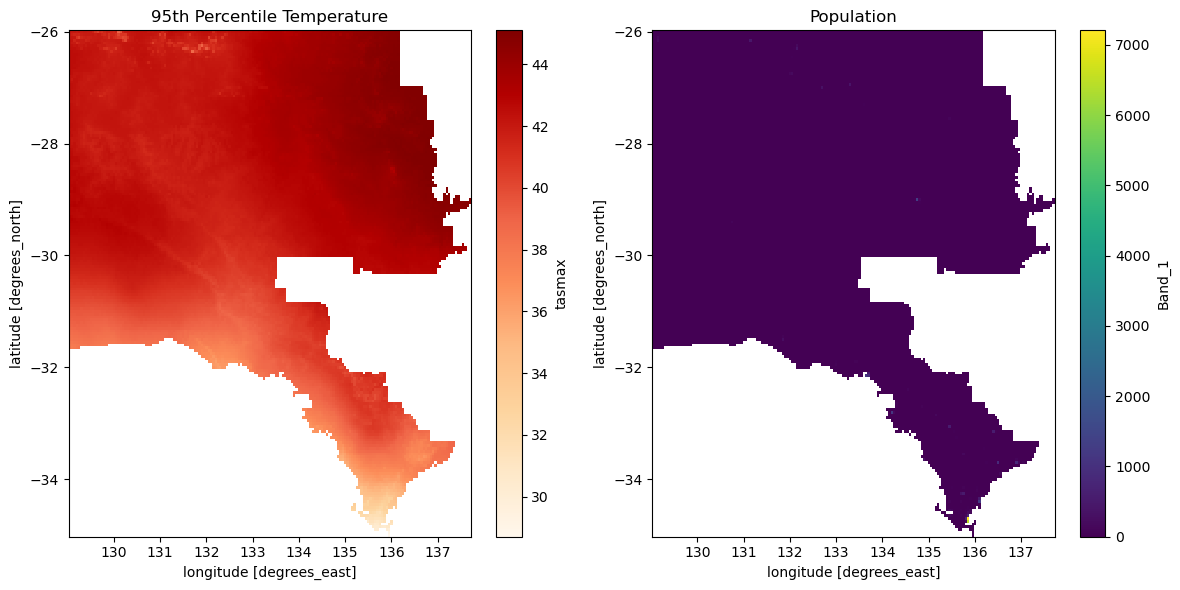

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

dist_pc_95.plot(ax=ax1, cmap="OrRd")
ax1.set_title('95th Percentile Temperature')

dist_pop.plot(ax=ax2, cmap='viridis')
ax2.set_title('Population')

plt.tight_layout()
plt.show()

In [ ]:
print(pc_dict['access_rcp85_mid'].rio.crs)

None


### Save and reload workspace dictionaries

In [ ]:
# Save key processed outputs to workspace

with open('netcdf-wrangle-workspace.pkl', 'wb') as f:
    dill.dump({
        'pc_dict': pc_dict,
        'hot_days_dict': hot_days_dict,
        'pc_dict_mean_95': pc_dict_mean_95,
        'ehf_dict': ehf_dict,
        'hi_dict': hi_dict_mean,
        'pc_dict_100': pc_dict_100,
        'pc_dict_min': pc_dict_min,
        'mean_dict': mean_dict
    }, f)

In [2]:
# reload

with open('netcdf-wrangle-workspace.pkl', 'rb') as f:
    saved = dill.load(f)

pc_dict = saved['pc_dict']
hot_days_dict = saved['hot_days_dict']
pc_dict_mean_95 = saved['pc_dict_mean_95']
pc_dict_100 = saved['pc_dict_100']
pc_dict_min = saved['pc_dict_min']
mean_dict = saved['mean_dict']

In [27]:
ras = hot_days_dict['access_rcp45_mid_days_above_35']

stats = []

nnsw = districts[districts['OBJECTID'] == 7].copy()

geom = [mapping(geom) for geom in nnsw.geometry]

affine = pop_aligned.rio.transform()

mask = geometry_mask(geom, transform=affine, invert=True, out_shape=ras.shape)



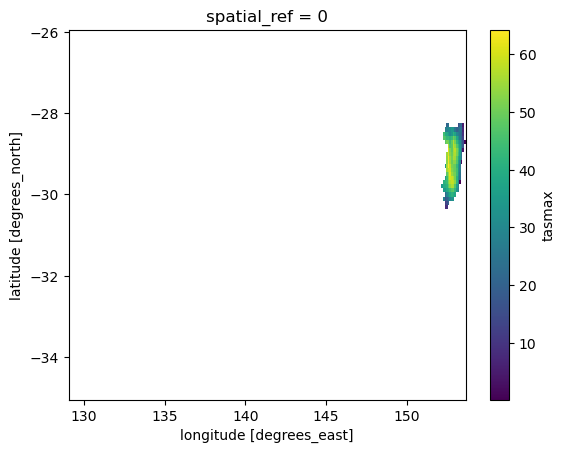

In [36]:
masked_ras = ras.where(mask)

masked_ras.plot()

In [39]:
vals = masked_ras.values
valid = vals[~np.isnan(vals)]

In [41]:
print(valid)

[ 8.32258065  8.77419355 11.77419355 14.70967742 20.67741935 27.67741935
 15.41935484 20.32258065 24.4516129  29.19354839 32.25806452 32.61290323
 21.83870968 29.25806452 33.61290323 38.87096774 41.51612903 40.06451613
 38.16129032 35.58064516 34.67741935 39.09677419 41.06451613 44.61290323
 47.41935484 47.96774194 42.64516129 32.83870968 28.09677419 34.03225806
 39.61290323 39.64516129 41.4516129  48.25806452 53.41935484 56.
 55.58064516 46.83870968 36.25806452 27.64516129 41.12903226 42.09677419
 43.83870968 51.77419355 56.90322581 58.32258065 57.70967742 52.96774194
 42.09677419 29.38709677  0.16129032 35.58064516 43.74193548 53.5483871
 60.06451613 58.90322581 56.4516129  51.         41.93548387 31.22580645
 22.96774194 48.38709677 54.58064516 61.32258065 54.41935484 51.5483871
 50.61290323 44.5483871  33.06451613 24.48387097 55.29032258 59.06451613
 59.90322581 52.41935484 50.25806452 49.22580645 44.80645161 34.16129032
 26.96774194 35.12903226 55.90322581 64.22580645 58.4516129  

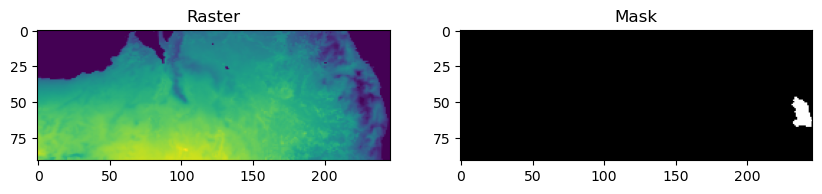

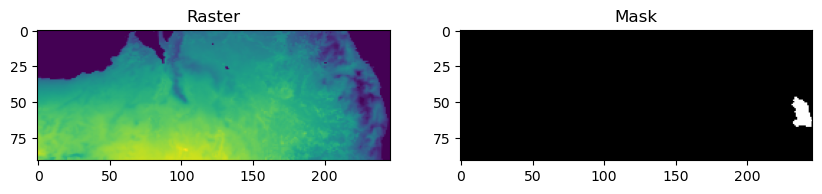

In [33]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(ras, cmap='viridis')
plt.title("Raster")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")

plt.show()

In [3]:
ras = hot_days_dict['access_rcp45_mid_days_above_35']

In [42]:
hot_days_dict['access_rcp45_mid_days_above_35'].rio.to_raster('test_hot_days.tif')


In [4]:
test = xr.open_dataset(ncdf_fold + '/tasmax_day_ACCESS-CM2_ssp245_r4i1p1f1_AUS-11_2035_qdc-additive-monthly-q100-linear_BARRA-R2-baseline-1985-2014_model-baseline-1985-2014.nc')

In [6]:
print(test)

<xarray.Dataset> Size: 2GB
Dimensions:  (lat: 646, lon: 1082, time: 365)
Coordinates:
  * lat      (lat) float64 5kB -57.97 -57.86 -57.75 -57.64 ... 12.76 12.87 12.98
  * lon      (lon) float64 9kB 88.48 88.59 88.7 88.81 ... 207.2 207.3 207.4
  * time     (time) datetime64[ns] 3kB 2035-01-01 2035-01-02 ... 2035-12-31
Data variables:
    tasmax   (time, lat, lon) float64 2GB ...
Attributes: (12/49)
    CDI:                       Climate Data Interface version 2.0.5 (https://...
    source:                    Data from Bureau of Meteorology Atmospheric hi...
    institution:               Commonwealth Scientific and Industrial Researc...
    Conventions:               CF-1.8, ACDD-1.3
    xclim:                     [2024-06-07 21:47:32] : Bias-adjusted with Qua...
    geospatial_lat_min:        -57.97
    ...                        ...
    project:                   QDC-CMIP6
    time_coverage_start:       20350101T0000Z
    time_coverage_end:         20351231T0000Z
    time_coverage_dur